# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band8.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.817934   
      201547 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.817934   
      201548 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.817934   
      201549 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.817934   
      201550 -0.953265  ...  -1.0 -0.869565 -0.922021  -1.0  -1.0 -0.817934   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.937446  -1.0 -0.861740  
      201547  -1.0 -0.937446  -1.0 -0.854589  
      201548  -1.0 -0.937446  -1.0 -0.856973  
      201549  -1.0 -0.937446  -1.0 -0.856973  
      201550  -1.0 -0.937446  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3         4    5         6    7  \
5360 201546 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.000000 -1.0   
     201547 -1.0 -1.0 -0.651103 -1.000000 -1.000000 -1.0 -1.000000 -1.0   
     201548 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.000000 -1.0   
     201549 -1.0 -1.0 -0.616857 -1.000000 -0.548070 -1.0 -0.888177 -1.0   
     201550 -1.0 -1.0 -0.962762 -0.802069 -0.875394 -1.0 -1.000000 -1.0   

                    8         9  ...      2039      2040      2041  2042  \
5360 201546 -1.000000 -0.953265  ... -1.000000 -0.869565 -0.922021  -1.0   
     201547 -0.997724 -1.000000  ... -0.994938 -0.776687 -1.000000  -1.0   
     201548 -1.000000 -0.953265  ... -1.000000 -0.869565 -0.922021  -1.0   
     201549 -0.885106 -0.968145  ... -1.000000 -0.845655 -1.000000  -1.0   
     201550 -1.000000 -0.953265  ... -1.000000 -0.869565 -0.922021  -1.0   

                 2043      2044  2045      2046      2047    Labels  
5360 201546 -1.000000 -0.817934  -1.0 -0.937446 -1.000000 -0.990465  
     201547 -0.977320 -1.000000  -1.0 -0.841555 -1.000000 -0.969011  
     201548 -1.000000 -0.817934  -1.0 -0.937446 -1.000000 -0.995232  
     201549 -0.904506 -1.000000  -1.0 -0.755744 -0.505306 -0.997616  
     201550 -1.000000 -0.817934  -1.0 -0.937446 -1.000000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

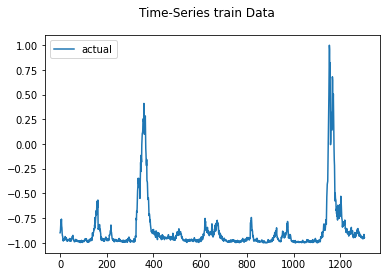

2023-03-06 15:15:53.252823: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:15:53.252872: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:15:53.252896: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 15:15:53.253088: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:15:53.491585: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 45.864
Test RMSE: 52.725
Test sMAPE: 127.577
Test R Squared: -1.559
{'mae': 45.86408086130224, 'rmse': 52.72497509705017, 'smape': 127.57726166509312, 'r2': -1.55869890213418}


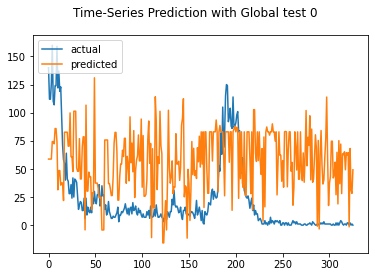

Test MAE: 42.016
Test RMSE: 50.169
Test sMAPE: 132.698
Test R Squared: -1.317
{'mae': 42.01610555550072, 'rmse': 50.16939623774509, 'smape': 132.6975682149512, 'r2': -1.3166699496805143}


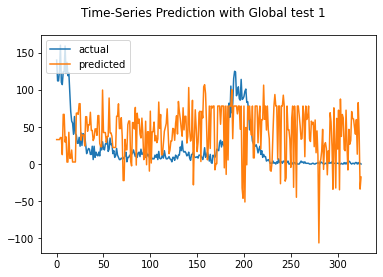

Test MAE: 53.960
Test RMSE: 66.625
Test sMAPE: 131.340
Test R Squared: -3.086
{'mae': 53.96001939758933, 'rmse': 66.62526644528783, 'smape': 131.33995216752766, 'r2': -3.0856798612171037}


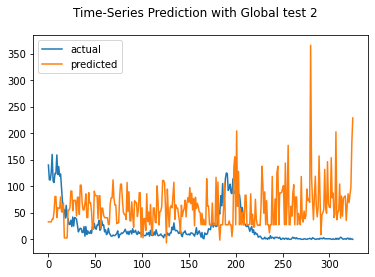

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.928
Test RMSE: 54.566
Test sMAPE: 140.330
Test R Squared: -1.741
{'mae': 43.92834588464784, 'rmse': 54.56604736591402, 'smape': 140.33006563726676, 'r2': -1.740510103593504}


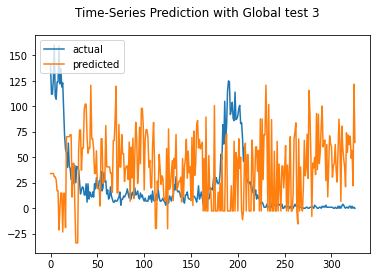

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.988
Test RMSE: 57.267
Test sMAPE: 133.912
Test R Squared: -2.019
{'mae': 48.988404614153815, 'rmse': 57.267190700859146, 'smape': 133.9115755777373, 'r2': -2.018548609755577}


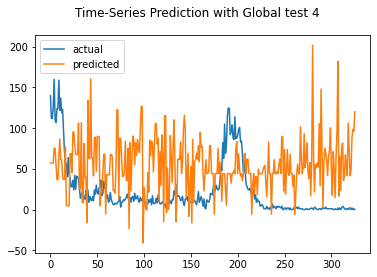

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 37.190
Test RMSE: 47.355
Test sMAPE: 123.592
Test R Squared: -1.064
{'mae': 37.19014451218529, 'rmse': 47.354555550502496, 'smape': 123.59195505436483, 'r2': -1.064001202342204}


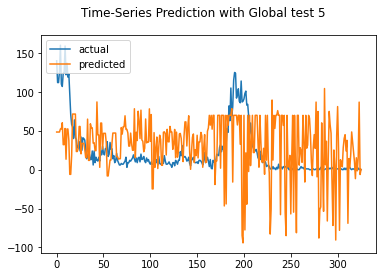

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 47.243
Test RMSE: 56.350
Test sMAPE: 137.421
Test R Squared: -1.923
{'mae': 47.24319652865635, 'rmse': 56.35016096130387, 'smape': 137.42068178140846, 'r2': -1.9226495170446705}


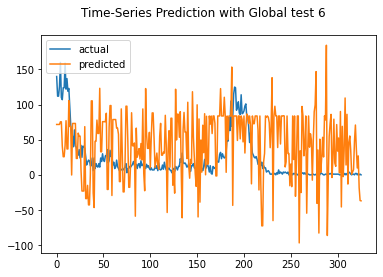

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 47.621
Test RMSE: 58.857
Test sMAPE: 137.416
Test R Squared: -2.189
{'mae': 47.62096945822604, 'rmse': 58.85728411836124, 'smape': 137.41560590407713, 'r2': -2.188503168710868}


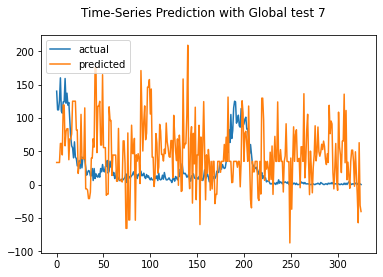

Test MAE: 60.186
Test RMSE: 86.312
Test sMAPE: 145.607
Test R Squared: -5.857
{'mae': 60.18647242168342, 'rmse': 86.31194780864199, 'smape': 145.60655748553606, 'r2': -5.856906873490773}


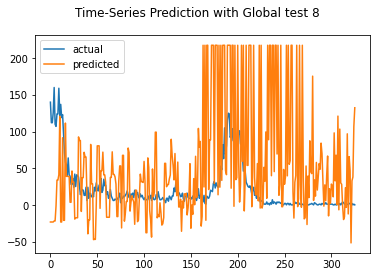

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 48.369
Test RMSE: 56.242
Test sMAPE: 130.095
Test R Squared: -1.911
{'mae': 48.36863760750718, 'rmse': 56.24236665154332, 'smape': 130.0953759786654, 'r2': -1.9114785229825184}


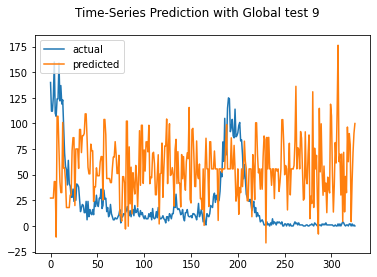

Test MAE: 62.230
Test RMSE: 73.040
Test sMAPE: 138.555
Test R Squared: -3.910
{'mae': 62.2299598389608, 'rmse': 73.04016788306706, 'smape': 138.5550093880847, 'r2': -3.9103216529691673}


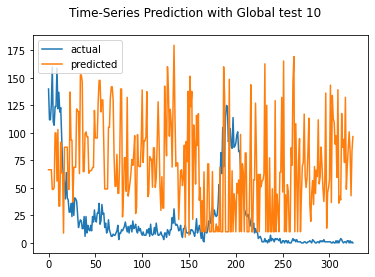

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 35.958
Test RMSE: 47.241
Test sMAPE: 128.034
Test R Squared: -1.054
{'mae': 35.958069959941085, 'rmse': 47.240766642564296, 'smape': 128.03435762704157, 'r2': -1.0540938865459224}


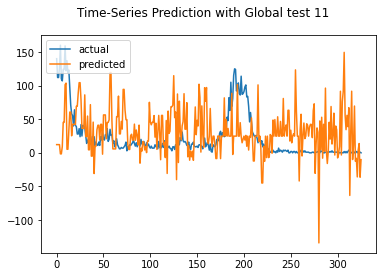

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.122
Test RMSE: 58.769
Test sMAPE: 127.979
Test R Squared: -2.179
{'mae': 49.12157664927968, 'rmse': 58.768556141184064, 'smape': 127.97855435984022, 'r2': -2.1788970104881}


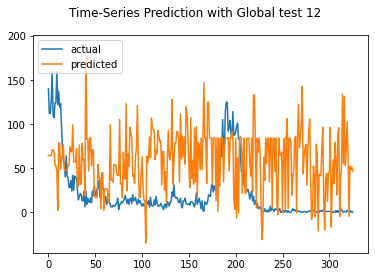

Test MAE: 74.945
Test RMSE: 108.150
Test sMAPE: 149.509
Test R Squared: -9.766
{'mae': 74.94479441277089, 'rmse': 108.1503336338947, 'smape': 149.50888870059322, 'r2': -9.765696772680302}


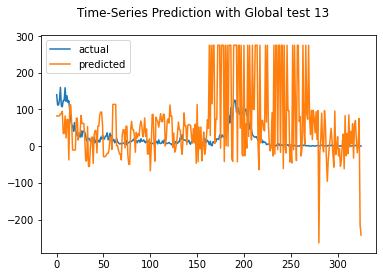

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 49.749
Test RMSE: 60.531
Test sMAPE: 137.239
Test R Squared: -2.372
{'mae': 49.74901874116593, 'rmse': 60.531477194145516, 'smape': 137.23850728636094, 'r2': -2.3724767251717496}


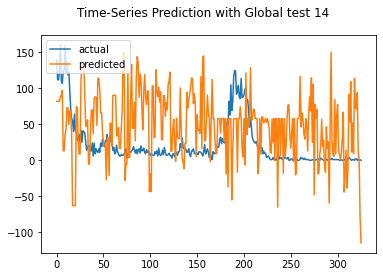

Test MAE: 124.628
Test RMSE: 155.263
Test sMAPE: 158.565
Test R Squared: -21.188
{'mae': 124.62810159607167, 'rmse': 155.2629324004128, 'smape': 158.564727198829, 'r2': -21.18819555063363}


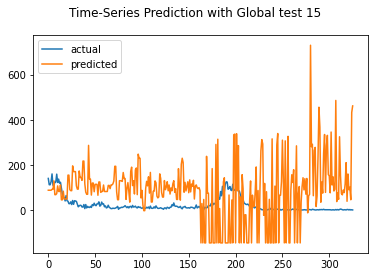

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 59.430
Test RMSE: 72.444
Test sMAPE: 149.852
Test R Squared: -3.831
{'mae': 59.42990216393412, 'rmse': 72.44408113311076, 'smape': 149.85184687425516, 'r2': -3.8305016276755435}


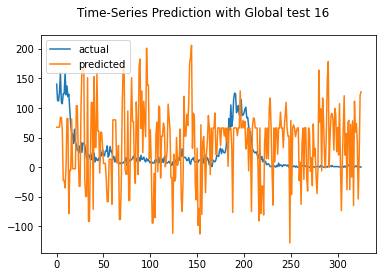

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 48.252
Test RMSE: 56.623
Test sMAPE: 134.544
Test R Squared: -1.951
{'mae': 48.25224498572525, 'rmse': 56.62349146864632, 'smape': 134.54367619505572, 'r2': -1.9510713245263407}


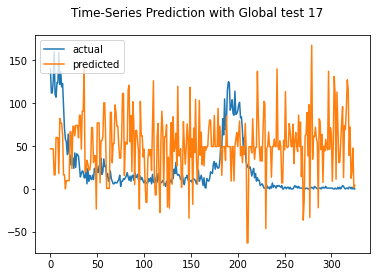

Test MAE: 62.467
Test RMSE: 74.215
Test sMAPE: 136.717
Test R Squared: -4.070
{'mae': 62.46679997553855, 'rmse': 74.21473492465418, 'smape': 136.71681548746812, 'r2': -4.069518326941757}


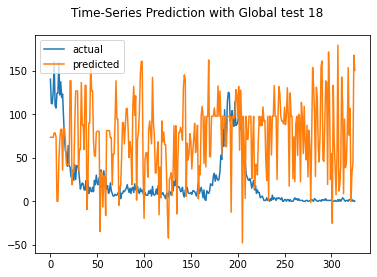

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 59.010
Test RMSE: 71.588
Test sMAPE: 153.005
Test R Squared: -3.717
{'mae': 59.00989249869724, 'rmse': 71.5882135957387, 'smape': 153.00522043000274, 'r2': -3.717038996571719}


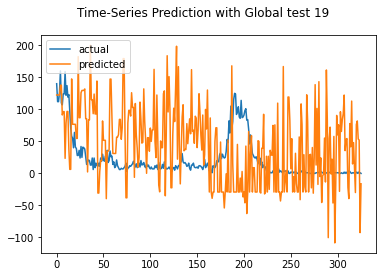

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 62.224
Test RMSE: 73.919
Test sMAPE: 136.647
Test R Squared: -4.029
{'mae': 62.22384368203169, 'rmse': 73.91912650209373, 'smape': 136.64749420808565, 'r2': -4.029213453299505}


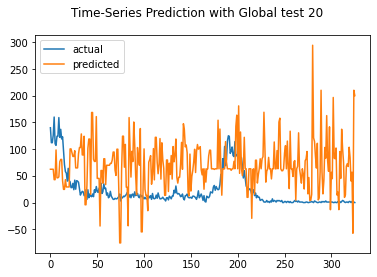

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 53.031
Test RMSE: 61.223
Test sMAPE: 139.420
Test R Squared: -2.450
{'mae': 53.031207268589114, 'rmse': 61.222534323822664, 'smape': 139.42008080759484, 'r2': -2.4499199888929306}


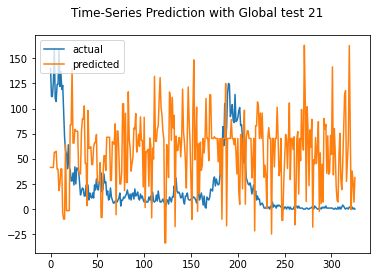

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 58.807
Test RMSE: 69.750
Test sMAPE: 134.321
Test R Squared: -3.478
{'mae': 58.806542773188255, 'rmse': 69.74953695514672, 'smape': 134.3213635329131, 'r2': -3.4778451792103082}


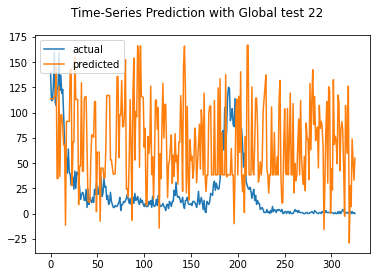

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 47.729
Test RMSE: 58.256
Test sMAPE: 140.081
Test R Squared: -2.124
{'mae': 47.728628179229844, 'rmse': 58.25633971528694, 'smape': 140.0807432155714, 'r2': -2.123725079924965}


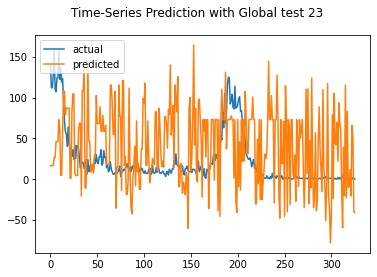

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 43.042
Test RMSE: 55.374
Test sMAPE: 129.375
Test R Squared: -1.822
{'mae': 43.04182271549672, 'rmse': 55.37352565325984, 'smape': 129.37504409630193, 'r2': -1.822219370748844}


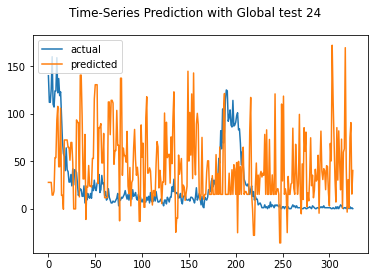

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 47.869
Test RMSE: 56.993
Test sMAPE: 142.973
Test R Squared: -1.990
{'mae': 47.86927543123441, 'rmse': 56.99303685178844, 'smape': 142.97306383116413, 'r2': -1.989716538107508}


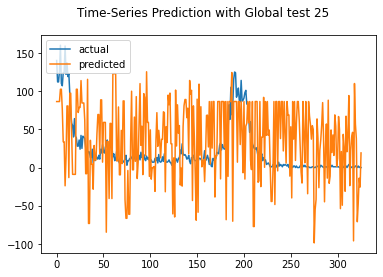

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 65.139
Test RMSE: 74.424
Test sMAPE: 151.129
Test R Squared: -4.098
{'mae': 65.1386424942982, 'rmse': 74.42375483737383, 'smape': 151.12907650068462, 'r2': -4.098114331808154}


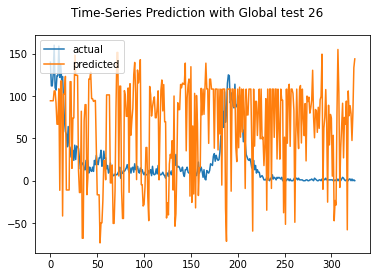

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 45.880
Test RMSE: 58.793
Test sMAPE: 131.869
Test R Squared: -2.182
{'mae': 45.880091024322745, 'rmse': 58.792813135859525, 'smape': 131.86853637791776, 'r2': -2.181521761095485}


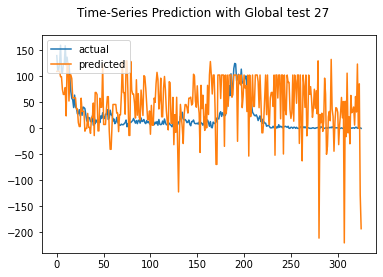

Test MAE: 76.294
Test RMSE: 95.810
Test sMAPE: 151.616
Test R Squared: -7.449
{'mae': 76.29414417919206, 'rmse': 95.8098822454656, 'smape': 151.6155915793739, 'r2': -7.44903344048201}


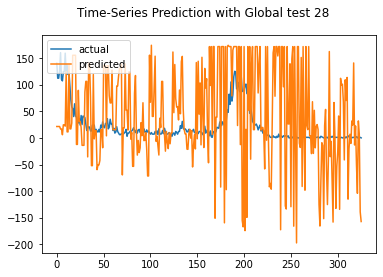

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 48.287
Test RMSE: 58.333
Test sMAPE: 140.601
Test R Squared: -2.132
{'mae': 48.2874818831865, 'rmse': 58.33263776226026, 'smape': 140.60069345483592, 'r2': -2.131912693378562}


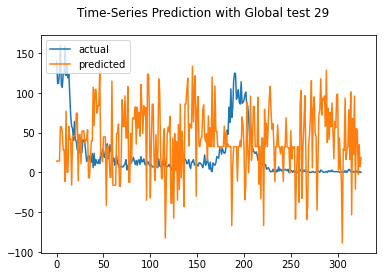

Test MAE: 62.106
Test RMSE: 73.376
Test sMAPE: 143.451
Test R Squared: -3.956
{'mae': 62.10578510146931, 'rmse': 73.37610245280958, 'smape': 143.45140407545173, 'r2': -3.9555937335362916}


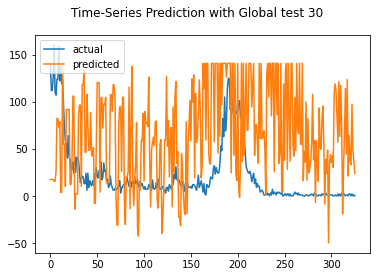

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 53.619
Test RMSE: 61.097
Test sMAPE: 133.822
Test R Squared: -2.436
{'mae': 53.61932770642766, 'rmse': 61.096578057153295, 'smape': 133.821973447632, 'r2': -2.4357391959169408}


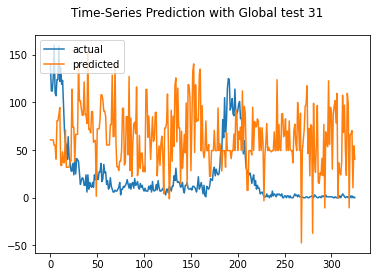

Test MAE: 57.252
Test RMSE: 68.530
Test sMAPE: 137.526
Test R Squared: -3.323
{'mae': 57.25197544931634, 'rmse': 68.53005317264171, 'smape': 137.52584292084592, 'r2': -3.322634882565639}


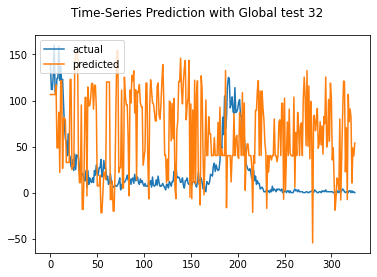

Test MAE: 65.615
Test RMSE: 83.259
Test sMAPE: 138.860
Test R Squared: -5.380
{'mae': 65.61516942568352, 'rmse': 83.25882075520765, 'smape': 138.8604385777524, 'r2': -5.380385612593402}


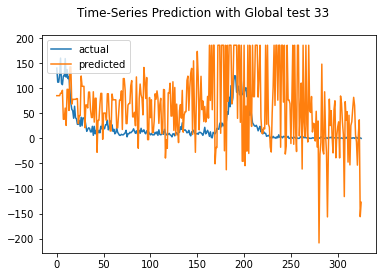

Test MAE: 71.870
Test RMSE: 93.721
Test sMAPE: 154.836
Test R Squared: -7.085
{'mae': 71.86961068368397, 'rmse': 93.72075565562648, 'smape': 154.83570501128236, 'r2': -7.084589614553371}


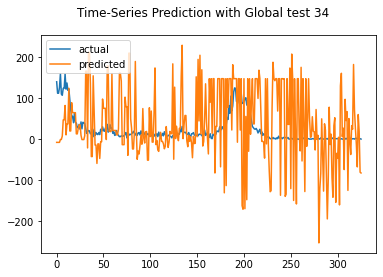

Test MAE: 75.635
Test RMSE: 86.998
Test sMAPE: 152.047
Test R Squared: -5.966
{'mae': 75.63530146783116, 'rmse': 86.99825759522605, 'smape': 152.0470700339299, 'r2': -5.966385854132649}


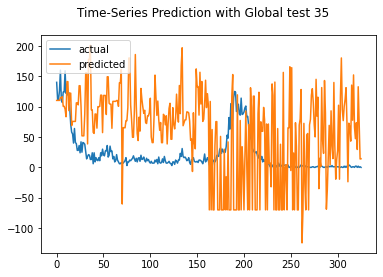

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.933
Test RMSE: 58.423
Test sMAPE: 146.158
Test R Squared: -2.142
{'mae': 48.932519872861405, 'rmse': 58.42323540888512, 'smape': 146.15786039469268, 'r2': -2.1416487270870537}


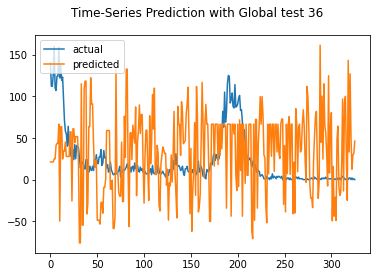

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.354
Test RMSE: 47.987
Test sMAPE: 123.187
Test R Squared: -1.119
{'mae': 40.35365284074304, 'rmse': 47.98660555909377, 'smape': 123.18677826986827, 'r2': -1.1194661100213956}


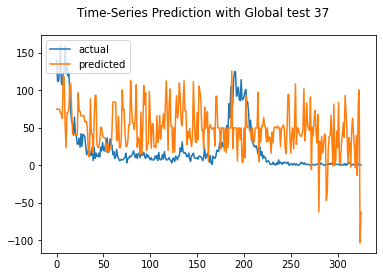

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 60.893
Test RMSE: 72.555
Test sMAPE: 139.400
Test R Squared: -3.845
{'mae': 60.893104737430264, 'rmse': 72.55478467065029, 'smape': 139.39959253372646, 'r2': -3.845276118422534}


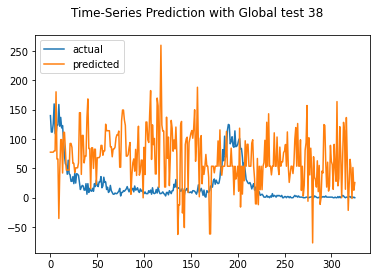

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 53.037
Test RMSE: 61.941
Test sMAPE: 131.367
Test R Squared: -2.531
{'mae': 53.037127381819154, 'rmse': 61.94054808267373, 'smape': 131.36749480627034, 'r2': -2.5313153645965722}


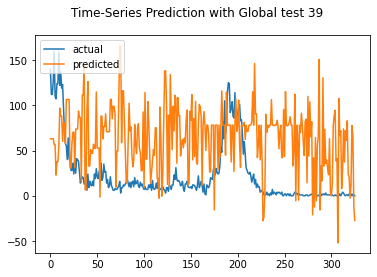

Test MAE: 54.671
Test RMSE: 78.535
Test sMAPE: 148.345
Test R Squared: -4.677
{'mae': 54.67136217790878, 'rmse': 78.53497893138965, 'smape': 148.34473048037893, 'r2': -4.676918761041121}


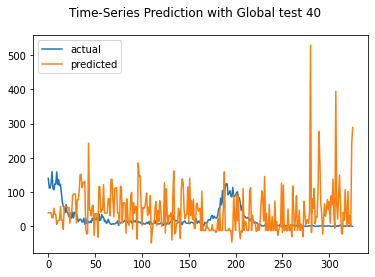

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 60.084
Test RMSE: 71.617
Test sMAPE: 140.189
Test R Squared: -3.721
{'mae': 60.08419937553581, 'rmse': 71.61675597512803, 'smape': 140.1889828254562, 'r2': -3.7208011342089087}


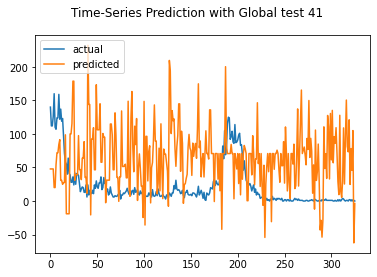

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.732
Test RMSE: 48.585
Test sMAPE: 135.557
Test R Squared: -1.173
{'mae': 39.732163549749394, 'rmse': 48.585240742577376, 'smape': 135.55699290517532, 'r2': -1.172676836545028}


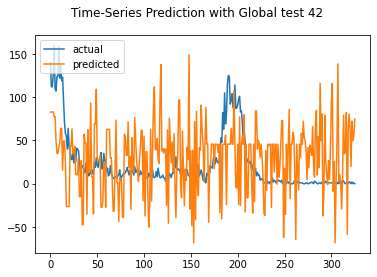

Test MAE: 53.019
Test RMSE: 60.618
Test sMAPE: 144.459
Test R Squared: -2.382
{'mae': 53.01935793998783, 'rmse': 60.617916669307775, 'smape': 144.45933787562979, 'r2': -2.3821154544644574}


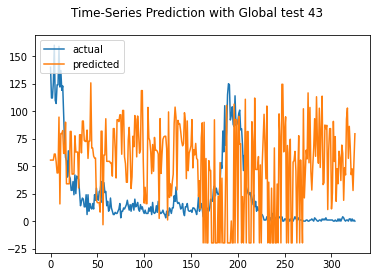

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.428
Test RMSE: 51.743
Test sMAPE: 128.291
Test R Squared: -1.464
{'mae': 45.427613273171566, 'rmse': 51.742981040751445, 'smape': 128.2908506650359, 'r2': -1.4642757763115695}


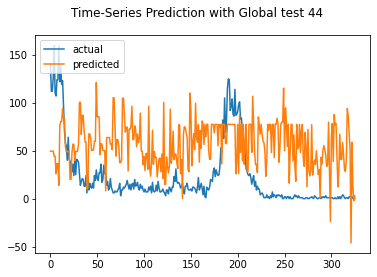

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.009
Test RMSE: 68.170
Test sMAPE: 138.890
Test R Squared: -3.277
{'mae': 53.009456622637124, 'rmse': 68.16978318662251, 'smape': 138.89021142378343, 'r2': -3.277305219226828}


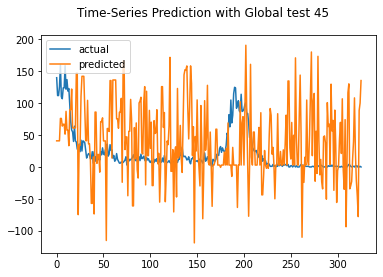

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 48.814
Test RMSE: 61.528
Test sMAPE: 139.117
Test R Squared: -2.484
{'mae': 48.8144717253059, 'rmse': 61.5284042735107, 'smape': 139.1168491179107, 'r2': -2.484477945059871}


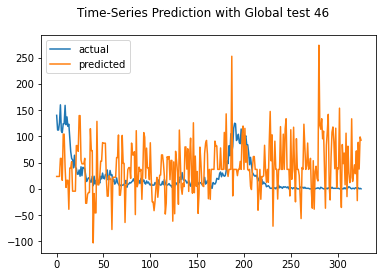

Test MAE: 68.072
Test RMSE: 83.485
Test sMAPE: 139.572
Test R Squared: -5.415
{'mae': 68.07183888316885, 'rmse': 83.48529489023586, 'smape': 139.57166591600839, 'r2': -5.415143673713976}


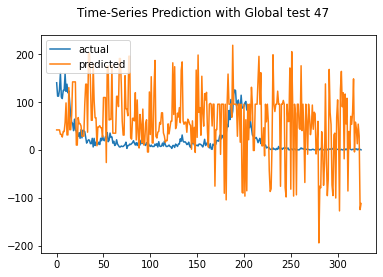

Test MAE: 103.790
Test RMSE: 121.323
Test sMAPE: 162.673
Test R Squared: -12.548
{'mae': 103.79043091989003, 'rmse': 121.32333519388524, 'smape': 162.67321000760418, 'r2': -12.54799717578379}


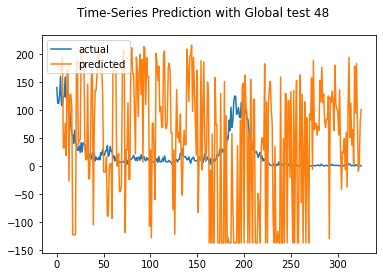

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 46.491
Test RMSE: 56.288
Test sMAPE: 126.277
Test R Squared: -1.916
{'mae': 46.49148604639469, 'rmse': 56.2879936273974, 'smape': 126.27710631769435, 'r2': -1.9162043498856285}


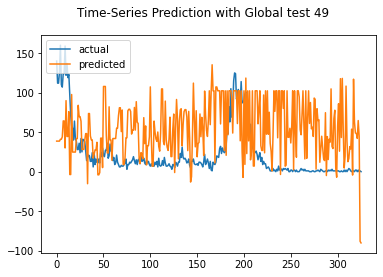

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 47.444
Test RMSE: 57.724
Test sMAPE: 141.012
Test R Squared: -2.067
{'mae': 47.443764738327154, 'rmse': 57.72431798333403, 'smape': 141.0121267168933, 'r2': -2.066931223910692}


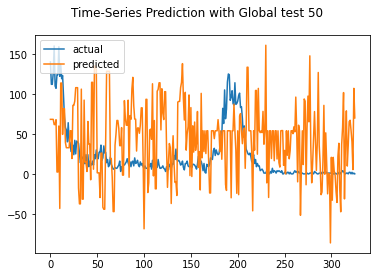

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 39.159
Test RMSE: 47.605
Test sMAPE: 126.371
Test R Squared: -1.086
{'mae': 39.15897552038263, 'rmse': 47.60472126283991, 'smape': 126.37106550248208, 'r2': -1.0858663089819878}


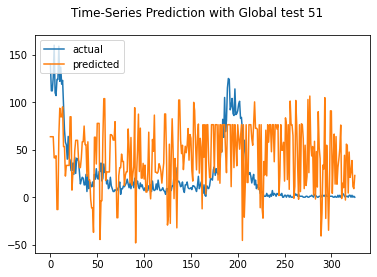

Test MAE: 50.818
Test RMSE: 58.537
Test sMAPE: 129.497
Test R Squared: -2.154
{'mae': 50.81763753276661, 'rmse': 58.53699792328768, 'smape': 129.4974733115267, 'r2': -2.1538955608998815}


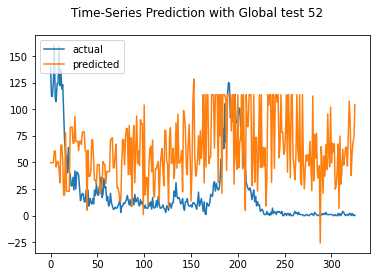

Test MAE: 76.969
Test RMSE: 99.118
Test sMAPE: 142.271
Test R Squared: -8.043
{'mae': 76.96850467898363, 'rmse': 99.11777510072976, 'smape': 142.2705181751593, 'r2': -8.042520581610137}


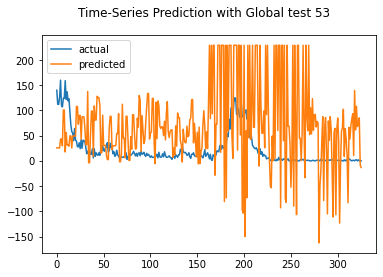

Test MAE: 74.852
Test RMSE: 87.804
Test sMAPE: 143.216
Test R Squared: -6.096
{'mae': 74.85162545310939, 'rmse': 87.80369432817317, 'smape': 143.21616712507983, 'r2': -6.095973656936206}


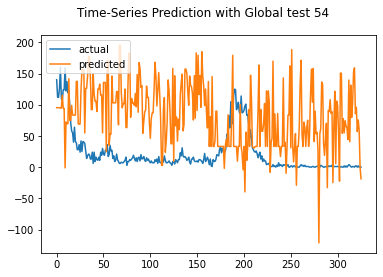

Test MAE: 68.572
Test RMSE: 78.329
Test sMAPE: 142.838
Test R Squared: -4.647
{'mae': 68.57209169809803, 'rmse': 78.32933509631211, 'smape': 142.83824692923005, 'r2': -4.6472276625688975}


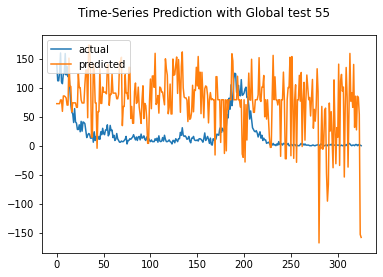

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 54.080
Test RMSE: 68.764
Test sMAPE: 155.081
Test R Squared: -3.352
{'mae': 54.07950647120461, 'rmse': 68.76357403097894, 'smape': 155.0808339946345, 'r2': -3.3521444248587837}


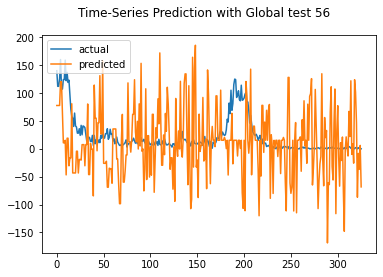

Test MAE: 67.749
Test RMSE: 79.921
Test sMAPE: 152.263
Test R Squared: -4.879
{'mae': 67.74937306362793, 'rmse': 79.9206354400572, 'smape': 152.26346716203847, 'r2': -4.879010999300218}


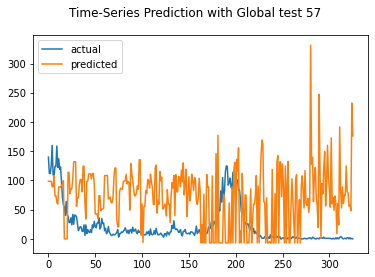

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 47.537
Test RMSE: 55.864
Test sMAPE: 134.533
Test R Squared: -1.872
{'mae': 47.53666364799248, 'rmse': 55.86394692847692, 'smape': 134.53259950991543, 'r2': -1.8724312910958267}


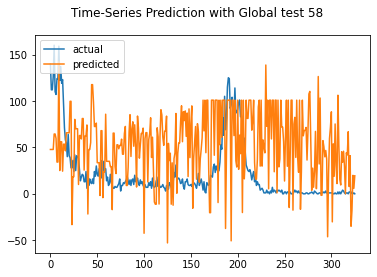

Test MAE: 57.859
Test RMSE: 69.216
Test sMAPE: 136.275
Test R Squared: -3.410
{'mae': 57.8589584534885, 'rmse': 69.21645549276035, 'smape': 136.274950695122, 'r2': -3.409660228639688}


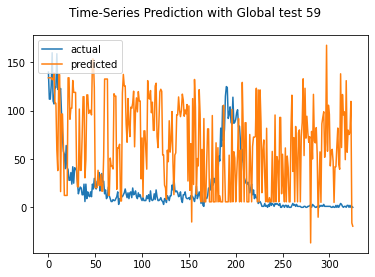

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 42.540
Test RMSE: 50.586
Test sMAPE: 134.178
Test R Squared: -1.355
{'mae': 42.539700219967614, 'rmse': 50.585685574847865, 'smape': 134.17848023256232, 'r2': -1.3552754035948276}


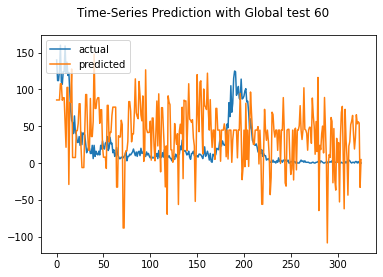

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 41.653
Test RMSE: 50.398
Test sMAPE: 131.340
Test R Squared: -1.338
{'mae': 41.653172582845016, 'rmse': 50.39757321928087, 'smape': 131.34028391799487, 'r2': -1.3377909075362133}


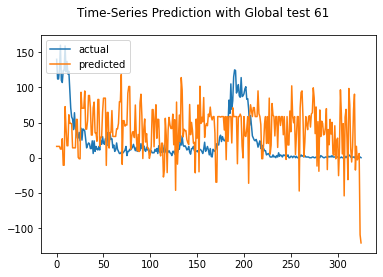

Test MAE: 103.490
Test RMSE: 132.112
Test sMAPE: 155.228
Test R Squared: -15.065
{'mae': 103.48959613687421, 'rmse': 132.11209979987254, 'smape': 155.22788526465433, 'r2': -15.06466253354759}


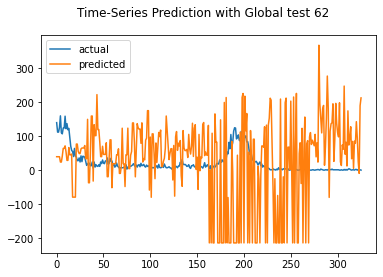

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.894
Test RMSE: 54.747
Test sMAPE: 125.230
Test R Squared: -1.759
{'mae': 44.89420132768666, 'rmse': 54.747282995037786, 'smape': 125.23016078051455, 'r2': -1.7587449924979275}


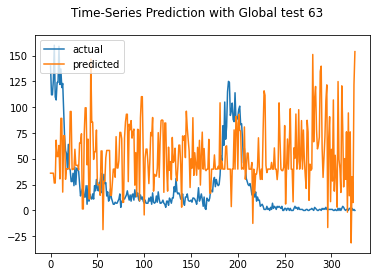

Test MAE: 44.455
Test RMSE: 57.400
Test sMAPE: 153.201
Test R Squared: -2.033
{'mae': 44.45462799483647, 'rmse': 57.39981894145954, 'smape': 153.2007487745843, 'r2': -2.032546446095995}


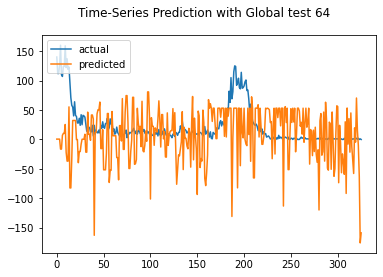

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 45.908
Test RMSE: 52.678
Test sMAPE: 129.620
Test R Squared: -1.554
{'mae': 45.9075686357504, 'rmse': 52.67821332619339, 'smape': 129.62010533801336, 'r2': -1.5541622955994066}


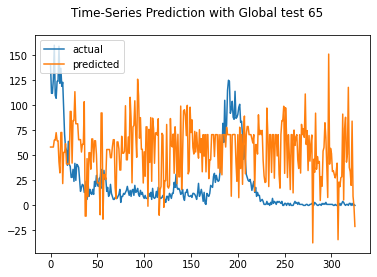

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 54.481
Test RMSE: 65.973
Test sMAPE: 138.206
Test R Squared: -3.006
{'mae': 54.481356744385934, 'rmse': 65.97340103915222, 'smape': 138.2060716116877, 'r2': -3.006121924759313}


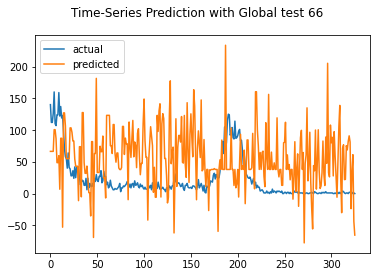

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.521
Test RMSE: 57.546
Test sMAPE: 131.572
Test R Squared: -2.048
{'mae': 49.521160499998395, 'rmse': 57.546271640408385, 'smape': 131.57180099106196, 'r2': -2.0480409616022195}


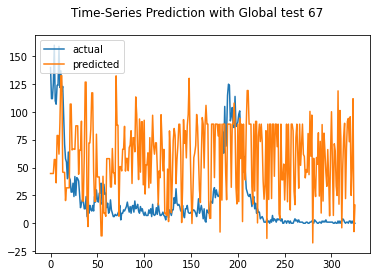

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 45.497
Test RMSE: 56.206
Test sMAPE: 147.264
Test R Squared: -1.908
{'mae': 45.496660552690365, 'rmse': 56.20616219363007, 'smape': 147.26434647854003, 'r2': -1.907731362931122}


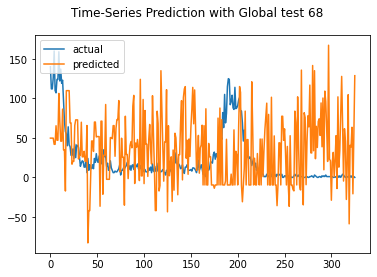

Test MAE: 79.260
Test RMSE: 91.540
Test sMAPE: 152.951
Test R Squared: -6.713
{'mae': 79.25987027612932, 'rmse': 91.53963376856498, 'smape': 152.95135857700586, 'r2': -6.712670135676768}


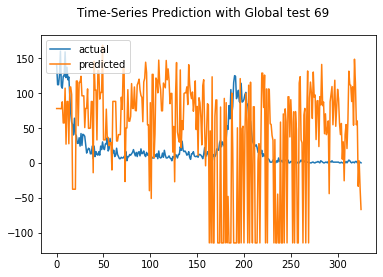

Test MAE: 104.118
Test RMSE: 123.291
Test sMAPE: 163.798
Test R Squared: -12.991
{'mae': 104.11765879081803, 'rmse': 123.29088724236534, 'smape': 163.79779945058064, 'r2': -12.990987612011311}


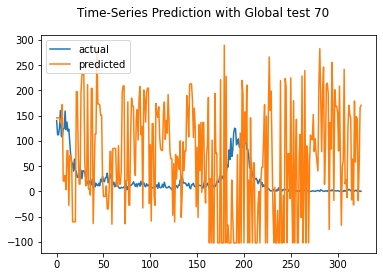

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 51.205
Test RMSE: 61.590
Test sMAPE: 140.373
Test R Squared: -2.491
{'mae': 51.20460373985987, 'rmse': 61.5899920404434, 'smape': 140.37344908105194, 'r2': -2.4914571158096774}


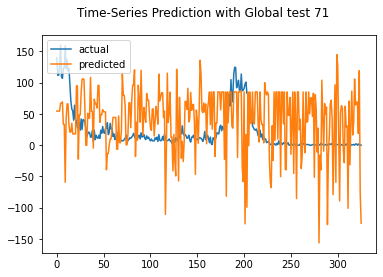

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 51.367
Test RMSE: 65.173
Test sMAPE: 144.639
Test R Squared: -2.910
{'mae': 51.36664122416198, 'rmse': 65.17349276038206, 'smape': 144.63859379943838, 'r2': -2.909564735163702}


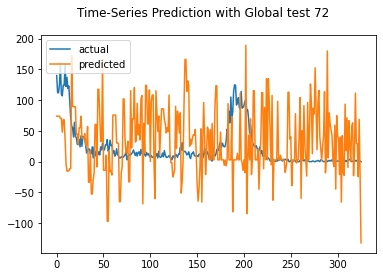

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 51.074
Test RMSE: 60.113
Test sMAPE: 145.963
Test R Squared: -2.326
{'mae': 51.0740860316651, 'rmse': 60.113490112277894, 'smape': 145.96269331891014, 'r2': -2.3260617111334505}


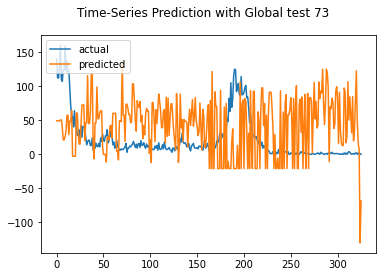

Test MAE: 94.902
Test RMSE: 102.511
Test sMAPE: 149.050
Test R Squared: -8.672
{'mae': 94.90249714529587, 'rmse': 102.51093810549591, 'smape': 149.04965334062734, 'r2': -8.672234826933847}


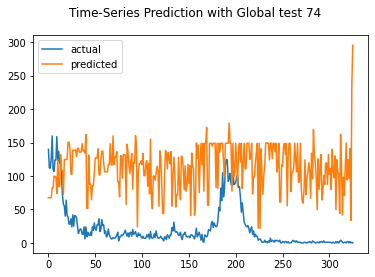

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 51.725
Test RMSE: 62.447
Test sMAPE: 144.803
Test R Squared: -2.589
{'mae': 51.72450771653579, 'rmse': 62.4467161952043, 'smape': 144.8027188460351, 'r2': -2.5892658548699807}


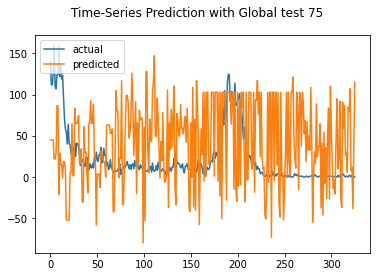

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 55.750
Test RMSE: 66.154
Test sMAPE: 141.940
Test R Squared: -3.028
{'mae': 55.75045398261649, 'rmse': 66.15412921629108, 'smape': 141.94011328158336, 'r2': -3.0281008069737076}


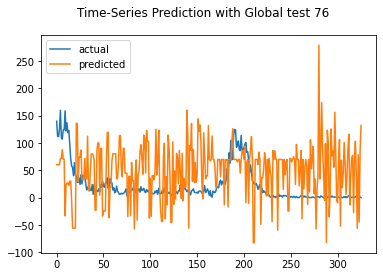

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 52.479
Test RMSE: 59.372
Test sMAPE: 131.890
Test R Squared: -2.245
{'mae': 52.47851346094915, 'rmse': 59.372092740332874, 'smape': 131.88957259869156, 'r2': -2.2445250422228264}


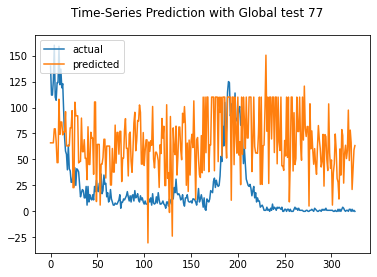

Test MAE: 51.086
Test RMSE: 56.909
Test sMAPE: 133.223
Test R Squared: -1.981
{'mae': 51.085952507206265, 'rmse': 56.90900291085797, 'smape': 133.22333572768738, 'r2': -1.9809066042308618}


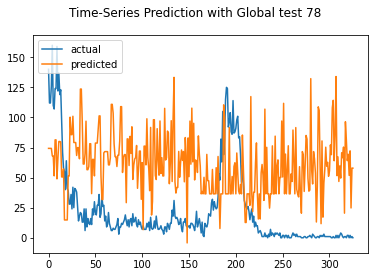

Test MAE: 48.357
Test RMSE: 60.325
Test sMAPE: 126.472
Test R Squared: -2.350
{'mae': 48.356653964958305, 'rmse': 60.32494562089809, 'smape': 126.47247524375224, 'r2': -2.349502408388996}


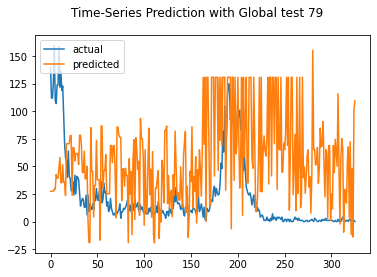

Test MAE: 115.420
Test RMSE: 163.954
Test sMAPE: 157.341
Test R Squared: -23.742
{'mae': 115.41968315876335, 'rmse': 163.95427363491996, 'smape': 157.34081303981102, 'r2': -23.74183459285282}


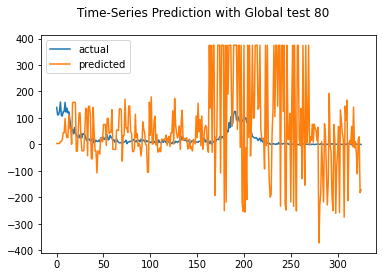

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 45.576
Test RMSE: 52.553
Test sMAPE: 130.567
Test R Squared: -1.542
{'mae': 45.57635637587565, 'rmse': 52.55348994578534, 'smape': 130.5674253895657, 'r2': -1.5420819074325447}


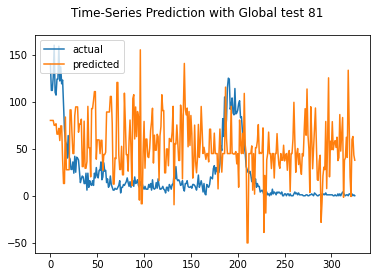

Test MAE: 56.055
Test RMSE: 64.222
Test sMAPE: 131.511
Test R Squared: -2.796
{'mae': 56.05463676328308, 'rmse': 64.22150073866017, 'smape': 131.51065329009936, 'r2': -2.7961845405622165}


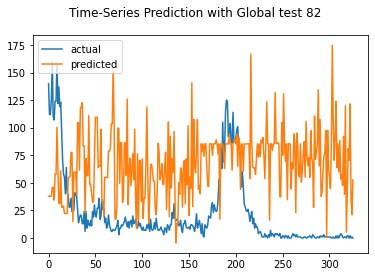

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 43.769
Test RMSE: 50.571
Test sMAPE: 127.805
Test R Squared: -1.354
{'mae': 43.76939262787989, 'rmse': 50.570835120839604, 'smape': 127.8051437329969, 'r2': -1.3538927288491989}


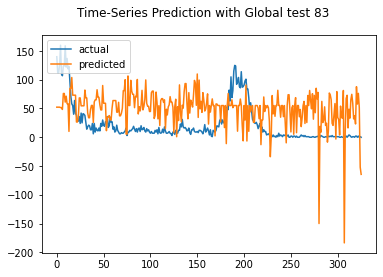

Test MAE: 69.631
Test RMSE: 80.558
Test sMAPE: 152.686
Test R Squared: -4.973
{'mae': 69.63075056635529, 'rmse': 80.55777873858025, 'smape': 152.68618169003764, 'r2': -4.973121949826246}


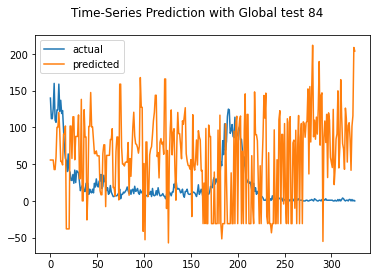

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 42.947
Test RMSE: 51.833
Test sMAPE: 128.957
Test R Squared: -1.473
{'mae': 42.947491230408836, 'rmse': 51.83274058313858, 'smape': 128.95737309785554, 'r2': -1.4728328449140848}


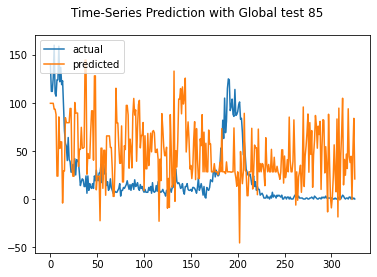

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 63.566
Test RMSE: 78.474
Test sMAPE: 150.129
Test R Squared: -4.668
{'mae': 63.56585189864679, 'rmse': 78.474270762036, 'smape': 150.12936563265382, 'r2': -4.668145545658755}


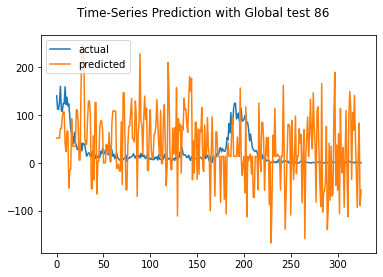

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.180
Test RMSE: 58.713
Test sMAPE: 134.805
Test R Squared: -2.173
{'mae': 48.17979406752835, 'rmse': 58.71345958733159, 'smape': 134.8048652012511, 'r2': -2.1729392609542675}


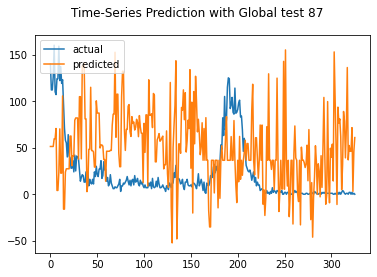

Test MAE: 45.397
Test RMSE: 57.919
Test sMAPE: 127.539
Test R Squared: -2.088
{'mae': 45.39653569642751, 'rmse': 57.918777777355615, 'smape': 127.5393921758243, 'r2': -2.0876295844152577}


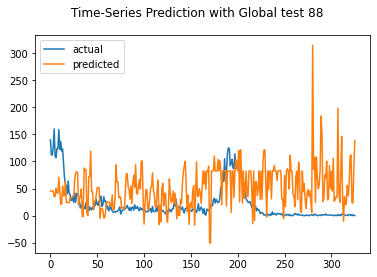

Test MAE: 74.068
Test RMSE: 111.989
Test sMAPE: 154.751
Test R Squared: -10.543
{'mae': 74.06835307985361, 'rmse': 111.98886617259187, 'smape': 154.7512433327274, 'r2': -10.54346290174017}


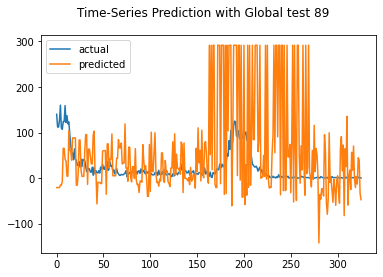

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 47.352
Test RMSE: 56.544
Test sMAPE: 136.472
Test R Squared: -1.943
{'mae': 47.35168967199472, 'rmse': 56.54406537872389, 'smape': 136.47166954673204, 'r2': -1.9427981623179953}


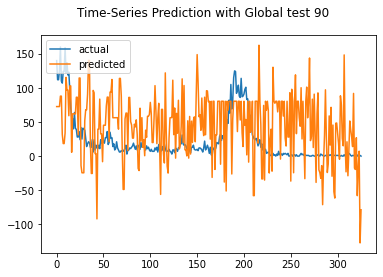

Test MAE: 107.841
Test RMSE: 129.874
Test sMAPE: 160.528
Test R Squared: -14.525
{'mae': 107.84123745341242, 'rmse': 129.87443897286408, 'smape': 160.52832612359114, 'r2': -14.525077801431655}


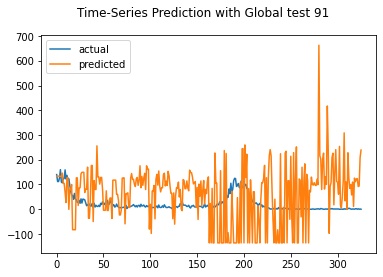

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 48.295
Test RMSE: 58.093
Test sMAPE: 130.783
Test R Squared: -2.106
{'mae': 48.29507426926695, 'rmse': 58.09269592617358, 'smape': 130.7828071027452, 'r2': -2.106200455022857}


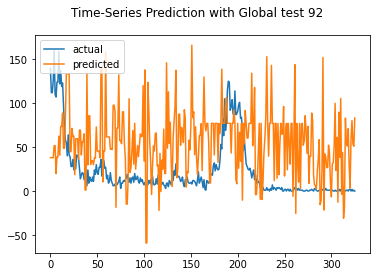

Test MAE: 57.824
Test RMSE: 62.672
Test sMAPE: 136.556
Test R Squared: -2.615
{'mae': 57.8236571835594, 'rmse': 62.6719344723812, 'smape': 136.55627089019615, 'r2': -2.6152023984945463}


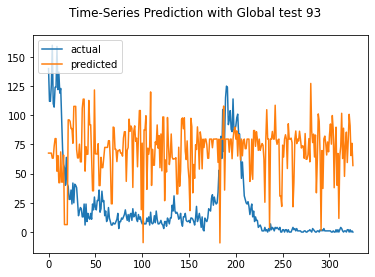

Test MAE: 51.773
Test RMSE: 73.633
Test sMAPE: 127.629
Test R Squared: -3.990
{'mae': 51.77257225923012, 'rmse': 73.63253238166554, 'smape': 127.62937131765695, 'r2': -3.9902912166199878}


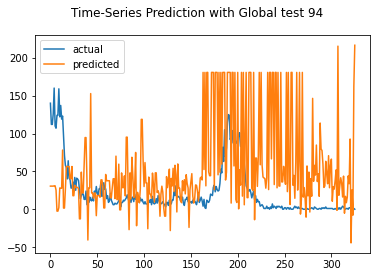

Test MAE: 53.914
Test RMSE: 63.564
Test sMAPE: 133.991
Test R Squared: -2.719
{'mae': 53.91371559273977, 'rmse': 63.564325642465356, 'smape': 133.99059803916438, 'r2': -2.718889754502944}


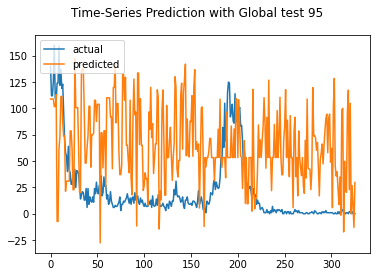

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.859
Test RMSE: 56.393
Test sMAPE: 131.609
Test R Squared: -1.927
{'mae': 47.85938021851464, 'rmse': 56.3930216347421, 'smape': 131.60920382970752, 'r2': -1.927097219203684}


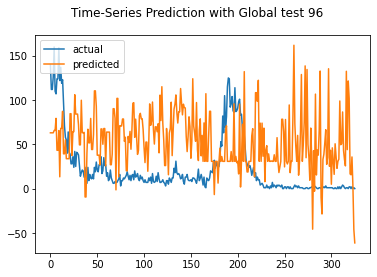

Test MAE: 40.780
Test RMSE: 46.989
Test sMAPE: 136.157
Test R Squared: -1.032
{'mae': 40.7803483375011, 'rmse': 46.98946286286966, 'smape': 136.15723329450378, 'r2': -1.0322979424322822}


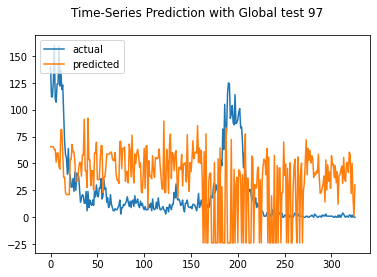

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 42.075
Test RMSE: 49.601
Test sMAPE: 130.885
Test R Squared: -1.264
{'mae': 42.07503585617967, 'rmse': 49.60091046652373, 'smape': 130.88516116474014, 'r2': -1.2644655239647276}


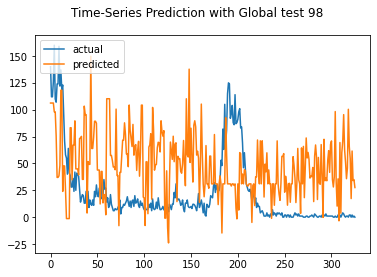

Test MAE: 73.156
Test RMSE: 103.987
Test sMAPE: 155.294
Test R Squared: -8.953
{'mae': 73.15575200483843, 'rmse': 103.98743910677119, 'smape': 155.29433263584406, 'r2': -8.952866577311173}


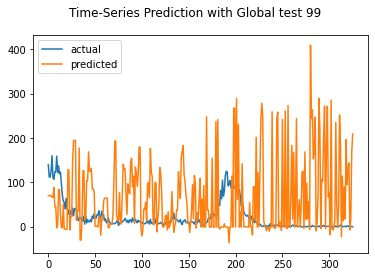

rmse : average=69.991, std=22.550
mae : average=57.362, std=17.119
smape : average=139.563, std=9.713
r2 : average=-3.977, std=3.901


([69.99075662814126, 22.549578749645146],
 [57.36158265580795, 17.118574069174706],
 [139.56336514529494, 9.713264486783858],
 [-3.976889604906609, 3.9011377547352666])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
